Use this IPython notebook on [Google Colaboratory](https://colab.research.google.com) to run SfMLearner CNN based depth and ego motion estimation.

SfMLearner original code here:

> An unsupervised learning framework for depth and ego-motion estimation from monocular videos

> https://github.com/tinghuiz/SfMLearner/

This currently works in Python 2.

Make sure you enable GPU in Colaboratory using menu path Runtime -> Change runtime type

Join our efforts in [Open Source Self Driving Car Initiative](http://OSSDC.org)!

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python && pip install -q -U pafy

In [0]:
#download realtime_object_detection Git repository
!rm master.zip
!wget  'https://codeload.github.com/tinghuiz/SfMLearner/zip/master' --output-document 'SfMLearner-master.zip'
!rm -r SfMLearner-master
!unzip SfMLearner-master.zip
!mv SfMLearner-master/* .

import sys

sys.path.append('.')

In [0]:
!bash ./models/download_depth_model.sh
!ls -l models/

In [0]:
%pylab inline
from __future__ import division
import os
import numpy as np
import PIL.Image as pil
import tensorflow as tf
from SfMLearner import SfMLearner
from utils import normalize_depth_for_display

img_height=128
img_width=416
ckpt_file = 'models/model-190532'
fh = open('misc/sample.png', 'r')
I = pil.open(fh)
I = I.resize((img_width, img_height), pil.ANTIALIAS)
I = np.array(I)

In [0]:
sfm = SfMLearner()
sfm.setup_inference(img_height,
                    img_width,
                    mode='depth')

In [7]:
saver = tf.train.Saver([var for var in tf.model_variables()]) 
with tf.Session() as sess:
    saver.restore(sess, ckpt_file)
    pred = sfm.inference(I[None,:,:,:], sess, mode='depth')

INFO:tensorflow:Restoring parameters from models/model-190532


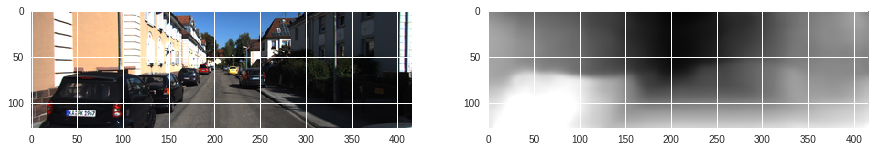

In [8]:
figure(figsize=(15,15))
subplot(1,2,1); imshow(I)
subplot(1,2,2); imshow(normalize_depth_for_display(pred['depth'][0,:,:,0]))

In [0]:
!rm video-test.mp4

Now we will process a video from Youtube

In [9]:
import time, pafy

start_time = time.time()

#A smooth drive in The Crew on PS4 - OSSDC Simulator ACC Train 30fps
url = 'https://www.youtube.com/watch?v=uuQlMCMT71I'

#Bad weather sample, uncomment this line to see how the detection works on bad weather
#url = "https://www.youtube.com/watch?v=q3q26xrigX4"

#url= ... #put your Youtube video URL here and uncomment the line, to test on a different video

def getVideoURL(url):
    videoUrl = url
    video = pafy.new(url)
    streams = video.streams
    videoUrlList={}
    for s in streams:
        videoUrlList[s.resolution] = s.url
        #print(s.resolution, s.extension, s.get_filesize(), s.url)

    if videoUrlList.get("1280x720",None) is not None:
        videoUrl = videoUrlList.get("1280x720",None)
        print("1280x720")

    if videoUrlList.get("1920x1080",None) is not None:
        videoUrl = videoUrlList.get("1920x1080",None)
        print("1920x1080")
    return videoUrl

origVideoUrl = url

if "youtube." in url: 
    videoUrl = getVideoURL(url)
    !wget -q -O video-test.mp4 '$videoUrl' #streaming directly doesn't work in Colaboratory yet, need to save the file on disk first
else:
    videoUrl = url

print("videoUrl =",videoUrl)
videoUrl='video-test.mp4'

1280x720
('videoUrl =', u'https://r2---sn-q4f7sn7s.googlevideo.com/videoplayback?ratebypass=yes&fvip=5&ipbits=0&itag=22&expire=1517512951&sparams=dur%2Cei%2Cid%2Cip%2Cipbits%2Citag%2Clmt%2Cmime%2Cmm%2Cmn%2Cms%2Cmv%2Cpl%2Cratebypass%2Crequiressl%2Csource%2Cexpire&mime=video%2Fmp4&mt=1517491045&mm=31%2C29&mn=sn-q4f7sn7s%2Csn-q4flrn7s&id=o-AEtz9zEH7qPK1vrb9USu4frvQaLN-Sk0JkETaOkiIdW8&signature=97C979727AA1DA365DF33F1A011A8DFB96AB733D.641E7CB0ED55A2537A86EED0D7A33BA34B302D9F&key=yt6&source=youtube&mv=u&dur=431.449&ei=lxRzWumiGcWo4QSm64PACw&ms=au%2Crdu&ip=35.229.21.194&requiressl=yes&pl=22&lmt=1486247047166339')


In [0]:

your_target_ip='put_your_target_ip_here'
your_target_port=45654

In [0]:
import cv2

%pylab inline 
from IPython.display import clear_output

cap = cv2.VideoCapture('video-test.mp4')   # /dev/video0
count=0

print (your_target_ip,your_target_port)

showImage=False
showImage=True


streamImage=False
#streamImage=True

import socket
if streamImage:
  #on server run this command:
  #ffplay -f mjpeg tcp://0.0.0.0:45654?listen
  clientsocket=socket.socket(socket.AF_INET,socket.SOCK_STREAM)
  clientsocket.connect((your_target_ip,your_target_port)) #the target ip is where the ffplay is listening

with tf.Session() as sess:
    saver.restore(sess, ckpt_file)
    while True:
      ret, frame = cap.read()
      if not ret:
        #print("no frame")
        continue
      
      count=count+1
      crop_img = frame[168:168+384, 16:16+1248]
      crop_img_resize = cv2.resize(crop_img, (416, 128), interpolation = cv2.INTER_AREA)
      pred = sfm.inference(crop_img_resize[None,:,:,:], sess, mode='depth')
      
      depth = normalize_depth_for_display(pred['depth'][0,:,:,0])                                          
      #depth = pred['depth'][0,:,:,0]
      
      #cv2.putText(image_np,"fps: {}".format(fps.fps_local()), (10,30),cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
    
      if streamImage:
        #data = cv2.imencode('.jpg', crop_img)[1].tobytes()
        data = cv2.imencode('.jpg', depth)[1].tobytes()
        clientsocket.send(data)

      if showImage:
        figure(figsize=(15,15))
        img = cv2.cvtColor(crop_img_resize, cv2.COLOR_RGB2BGR)
        subplot(1,2,1); imshow(img)
        subplot(1,2,2); imshow(depth)        
        #imshow(depth)
        show()
        if count % 2: #increase or decrease this to clear after more or less frames
          # Display the frame until new frame is available
          clear_output(wait=True)

      if(count==1000):
        break
      
      
if streamImage:
  clientsocket.close()      